In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import pandas as pd
pd.set_option("display.max_row", None)


In [62]:
from absbox import API,mkDeal,Endpoints,SPV,Generic
localAPI = API("http://localhost:8081",check=False)

⠋ Connecting engine server -> http://localhost:8081
✅Connected, local lib:0.20.2, server:0.24.3


In [63]:
test01 = Generic(
    "TEST01"
    ,{"cutoff":"2021-03-01","closing":"2021-06-15","firstPay":"2021-07-26"
     ,"payFreq":["DayOfMonth",20],"poolFreq":"MonthEnd","stated":"2030-01-01"}
    ,{'assets':[["Mortgage"
        ,{"originBalance":2200,"originRate":["fix",0.045],"originTerm":30
          ,"freq":"Monthly","type":"Level","originDate":"2021-02-01"}
          ,{"currentBalance":2200
          ,"currentRate":0.08
          ,"remainTerm":20
          ,"status":"current"}]]}
    ,(("acc01",{"balance":0}),)
    ,(("A1",{"balance":1000
             ,"rate":0.07
             ,"originBalance":1000
             ,"originRate":0.07
             ,"startDate":"2020-01-03"
             ,"rateType":{"Fixed":0.08}
             ,"bondType":{"Sequential":None}})
      ,("B",{"balance":1000
             ,"rate":0.0
             ,"originBalance":1000
             ,"originRate":0.07
             ,"startDate":"2020-01-03"
             ,"rateType":{"Fixed":0.00}
             ,"bondType":{"Equity":None}
             }))
    ,(("trusteeFee",{"type":{"fixFee":30}}),)
    ,{"amortizing":[
         ["payFee","acc01",['trusteeFee']]
         ,["accrueAndPayInt","acc01",["A1"]]
         ,["payPrin","acc01",["A1"]]
         ,["payPrin","acc01",["B"]]
         ,["payIntResidual","acc01","B"]
     ]}
    ,[["CollectedInterest","acc01"]
      ,["CollectedPrincipal","acc01"]
      ,["CollectedPrepayment","acc01"]
      ,["CollectedRecoveries","acc01"]]
    ,None
    ,None
    ,None
    ,None
    ,("PreClosing","Amortizing")
    )

In [64]:
from absbox.local.chart import viz

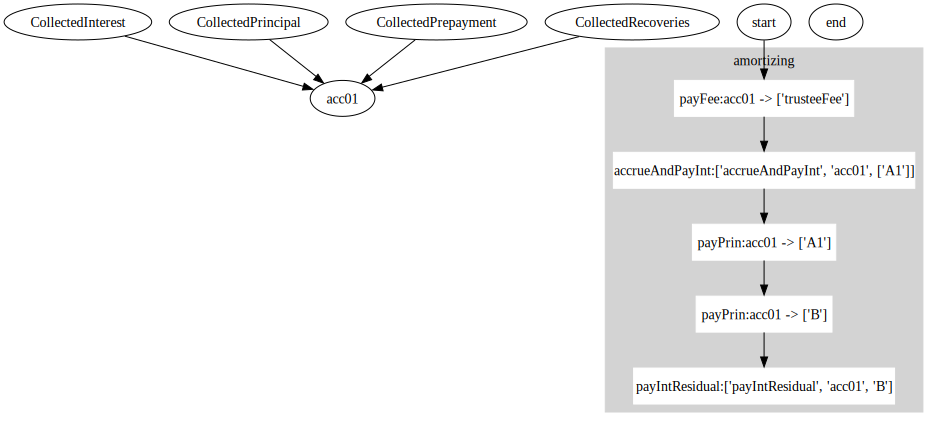

In [66]:
viz(test01)

In [54]:
revol_asset = ["Mortgage"
                ,{"originBalance":220,"originRate":["fix",0.043],"originTerm":48
                  ,"freq":"Monthly","type":"Level","originDate":"2021-07-01"}
                  ,{"currentBalance":220
                  ,"currentRate":0.043
                  ,"remainTerm":36
                  ,"status":"current"}]

r = localAPI.run(德宝天元202301,
           runAssump = [
               ("revolving"
                 ,["constant",revol_asset]
                 ,("Pool",("Mortgage",{"CDR":0.01},None,None,None)
                           ,None
                           ,None))
               ,("call",{"bondFactor":0.05})
               ,("report",{"dates":"MonthEnd"})
           ],
           poolAssump = ("Pool",("Mortgage",{"CDR":0.0012},None,None,None)
                           ,None
                           ,None)
           ,read=True)

⠹

<Axes: title={'center': '循环资产池余额变化'}, xlabel='日期', ylabel='资产池余额'>

/opt/homebrew/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Glyph 36164 (\N{CJK UNIFIED IDEOGRAPH-8D44}) missing from current font.
  func(*args, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Glyph 20135 (\N{CJK UNIFIED IDEOGRAPH-4EA7}) missing from current font.
  func(*args, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Glyph 27744 (\N{CJK UNIFIED IDEOGRAPH-6C60}) missing from current font.
  func(*args, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Glyph 20313 (\N{CJK UNIFIED IDEOGRAPH-4F59}) missing from current font.
  func(*args, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from current font.
  func(*args, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Glyph 24490 (\N{CJK UN

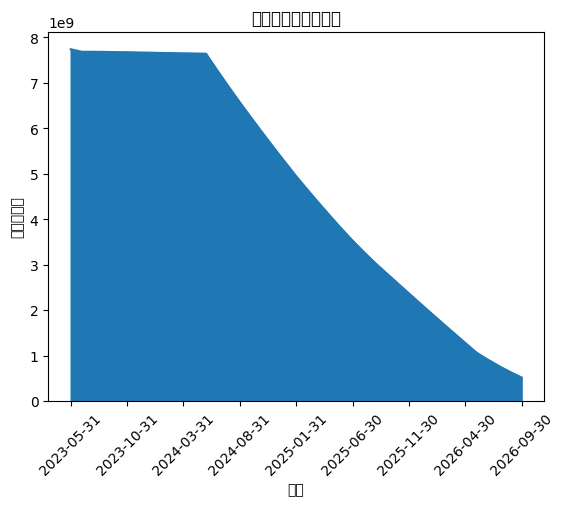

In [55]:
r['pool']['flow']['余额'].iloc[2:,].plot.area(rot=45
                                             ,title="循环资产池余额变化"
                                             ,ylabel="资产池余额"
                                             )

In [51]:
# view pool balance changes
r['pool']['flow']['余额'].iloc[2:,].plot.area(rot=45
                                             ,title="循环资产池余额变化"
                                             ,ylabel="资产池余额"
                                             )
# view balance sheet
bs = r['result']['report']['balanceSheet']

# view capital structure
col_to_keep = [('asset', 'Pool Performing')
               ,('asset', '现金储备分账户')
               ,('liability', 'A')
               ,('liability', '次级')
               #,('ratio',"A-OC")
              ]
start_index = 25
chart = bs.iloc[start_index:50,][col_to_keep].plot.area(rot=45,stacked=True,secondary_y=['OC-A'])
chart.set_title("资产负债结构")


# scenario analysis on revolving
rates = (0.043,0.065)
terms = ((24,12),(48,36))

rAssets = [["Mortgage"
           ,{"originBalance":220,"originRate":["fix",r],"originTerm":t[0]
           ,"freq":"Monthly","type":"Level","originDate":"2021-07-01"}
           ,{"currentBalance":220
           ,"currentRate":r
           ,"remainTerm":t[1]
           ,"status":"current"}]
           for r in rates 
           for t in terms ]

revol_low_rate_short_term, revol_low_rate_long_term, revol_high_rate_short_term, revol_high_rate_long_term = rAssets

scenarios=[("low_rate_long_term",revol_low_rate_long_term)
          ,("low_rate_short_term",revol_low_rate_short_term)
          ,("high_rate_long_term",revol_high_rate_long_term)
          ,("high_rate_short_term",revol_high_rate_short_term)]

base_assumption = [{"CDR":0.0012}
                   ,{"清仓":[{"债券余额剩余比率":0.05}]}
                   ,{"FinancialReports":{"dates":"MonthEnd"}}]

multiScenario = {k:base_assumption+[{"RevolvingAssets":[["constant",[v]]
                                                        ,[{"CDR":0.0012}]]}] 
                   for (k,v) in scenarios}

# scenario run
rm = localAPI.run(德宝天元202301,
                   assumptions=multiScenario,
                   pricing= {"贴现日":"2023-05-26","贴现曲线":[["2020-01-01",0.0275]]},
                   read=True)

# view scenario run result
import pandas
pandas.DataFrame.from_dict(
    {scenarioName:
        (f"{result['fees']['宝马金融服务商费用']['支付'].sum().round(2):,}"
         ,f"{result['bonds']['次级']['利息'].sum().round(2):,}"
         ,f"{result['fees']['宝马金融']['支付'].sum().round(2):,}"
         ,f"{result['pricing'].loc['A']['WAL']}")
        for (scenarioName,result) in rm.items()}
     , orient='index'
     , columns=["服务商费用"
                ,"次级超额收益"
                ,"原始权益人剩余收益"
                ,"优先级平均期限"])


TypeError: API.run() got an unexpected keyword argument 'assumptions'

In [49]:
r['bonds']['B']

,余额,利息,本金,执行利率,本息合计,备注
日期,,,,,,
2021-06-26,40.00,0.00,0.00,0.16,0.00,"[[<PayInt:B>, <PayPrin:B>], <PayYield:B>]"
2021-07-26,40.00,0.00,0.00,0.16,0.00,"[[<PayInt:B>, <PayPrin:B>], <PayYield:B>]"
2021-08-26,40.00,0.00,0.00,0.16,0.00,"[[<PayInt:B>, <PayPrin:B>], <PayYield:B>]"
2021-09-26,40.00,0.00,0.00,0.16,0.00,"[[<PayInt:B>, <PayPrin:B>], <PayYield:B>]"
2021-10-26,40.00,0.00,0.00,0.16,0.00,"[[<PayInt:B>, <PayPrin:B>], <PayYield:B>]"
2021-11-26,40.00,0.00,0.00,0.16,0.00,"[[<PayInt:B>, <PayPrin:B>], <PayYield:B>]"
2021-12-26,40.00,0.00,0.00,0.16,0.00,"[[<PayInt:B>, <PayPrin:B>], <PayYield:B>]"
2022-01-26,40.00,0.00,0.00,0.16,0.00,"[[<PayInt:B>, <PayPrin:B>], <PayYield:B>]"
2022-02-26,40.00,0.00,0.00,0.16,0.00,"[[<PayInt:B>, <PayPrin:B>], <PayYield:B>]"


In [69]:
r['accounts'].keys()

odict_keys(['账户01', '账户02'])

In [70]:
r.keys()

dict_keys(['bonds', 'fees', 'accounts', 'agg_accounts', 'pool', 'pricing', 'result', '_deal'])

In [71]:
r['result']

{'bonds': Empty DataFrame
 Columns: [本金违约, 利息违约, 起算余额, Total]
 Index: [],
 'status': Empty DataFrame
 Columns: [日期, 旧状态, 新状态]
 Index: [],
 'waterfallInspect': None,
 'logs':     Type                                            Comment
 0  Error  Failed to find index fromList [LPR5Y]in assump...}

In [62]:
r['bonds']["A1"]

,余额,利息,本金,执行利率,本息合计,备注
日期,,,,,,


In [65]:
r['accounts']['账户02']

,余额,变动额,备注
日期,,,


In [11]:
r['pool']['flow']

,余额,本金,利息,早偿金额,违约金额,回收金额,损失金额,利率,债务人数量,早偿手续费,累计还款,累计早偿,累计拖欠,累计违约,累计回收,累计损失
日期,,,,,,,,,,,,,,,,
2021-06-15,120,0,0.00,0,0,0,0,0.08,None,None,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,120,0,0.00,0,0,0,0,0.08,None,None,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-31,120,0,0.00,0,0,0,0,0.08,None,None,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-31,120,0,0.00,0,0,0,0,0.08,None,None,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-30,120,0,0.00,0,0,0,0,0.08,None,None,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-31,120,0,0.00,0,0,0,0,0.08,None,None,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-30,120,0,0.00,0,0,0,0,0.08,None,None,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-31,120,0,0.00,0,0,0,0,0.08,None,None,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-31,114,6,0.79,0,0,0,0,0.08,None,None,6.0,0.0,0.0,0.0,0.0,0.0
